# CSC3831 Part 3 Coursework


## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Task 1

## Loading and Preprocessing the CIFAR-10 Dataset


In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("Training on CPU")
else:
    print("Training on GPU")

Training on GPU


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_data = random_split(train_data, [train_size, val_size])

batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Adapted from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define the CNN Architecture

In [4]:
class CNN(nn.Module):
    def __init__(self, img_height, img_width, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        flattened_size = (img_height // 8) * (img_width // 8) * 128
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_height = 32
img_width =  32
num_classes = 10
model = CNN(img_height, img_width, num_classes).to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## Implement Training Function with Early Stopping

In [5]:
def train_func(train_loader, val_loader, model, loss_fn, optimizer, epochs=10, patience=5):

    model.train()
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
    best_val_loss = float("inf")
    early_stop_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = loss_fn(output, target)
            train_loss += loss.item()

            preds = output.argmax(dim=1)
            train_correct += (preds == target).sum().item()
            train_total += target.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)

                output = model(data)
                loss = loss_fn(output, target)
                val_loss += loss.item()

                preds = output.argmax(dim=1)
                val_correct += (preds == target).sum().item()
                val_total += target.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            best_model_state = model.state_dict()
            torch.save(best_model_state, "best_model_state.pth")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping! Triggered after {epoch + 1} epochs!")
                model.load_state_dict(best_model_state)
                break

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return history

# Adapted from: https://gist.github.com/MLWhiz/2cd4712647f72d4078caf4d76b650717

## Implement Testing Function

In [6]:
def test_func(test_loader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = loss_fn(output, target)
            total_loss += loss.item()

            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total

    print(f"Testset Accuracy: {100 * accuracy:.2f}%, Average Loss: {avg_loss:.4f}")
    return avg_loss, accuracy

## Training and Evaluating the Model

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
patience = 5
train_history = train_func(train_loader, val_loader, model, loss_fn, optimizer, epochs, patience)

Epoch 1/50, Train Loss: 1.3561, Train Acc: 0.5059, Val Loss: 1.0077, Val Acc: 0.6349
Epoch 2/50, Train Loss: 0.8999, Train Acc: 0.6833, Val Loss: 0.7316, Val Acc: 0.7407
Epoch 3/50, Train Loss: 0.7205, Train Acc: 0.7472, Val Loss: 0.6079, Val Acc: 0.7837
Epoch 4/50, Train Loss: 0.5914, Train Acc: 0.7939, Val Loss: 0.4723, Val Acc: 0.8406
Epoch 5/50, Train Loss: 0.4944, Train Acc: 0.8268, Val Loss: 0.4439, Val Acc: 0.8530
Epoch 6/50, Train Loss: 0.4182, Train Acc: 0.8547, Val Loss: 0.3257, Val Acc: 0.8858
Epoch 7/50, Train Loss: 0.3508, Train Acc: 0.8770, Val Loss: 0.2817, Val Acc: 0.9018
Epoch 8/50, Train Loss: 0.2947, Train Acc: 0.8969, Val Loss: 0.2726, Val Acc: 0.9046
Epoch 9/50, Train Loss: 0.2521, Train Acc: 0.9102, Val Loss: 0.1588, Val Acc: 0.9478
Epoch 10/50, Train Loss: 0.2210, Train Acc: 0.9238, Val Loss: 0.2058, Val Acc: 0.9289
Epoch 11/50, Train Loss: 0.1940, Train Acc: 0.9332, Val Loss: 0.1341, Val Acc: 0.9546
Epoch 12/50, Train Loss: 0.1758, Train Acc: 0.9396, Val Loss: 0

## Visualising Loss and Accuracy during Training

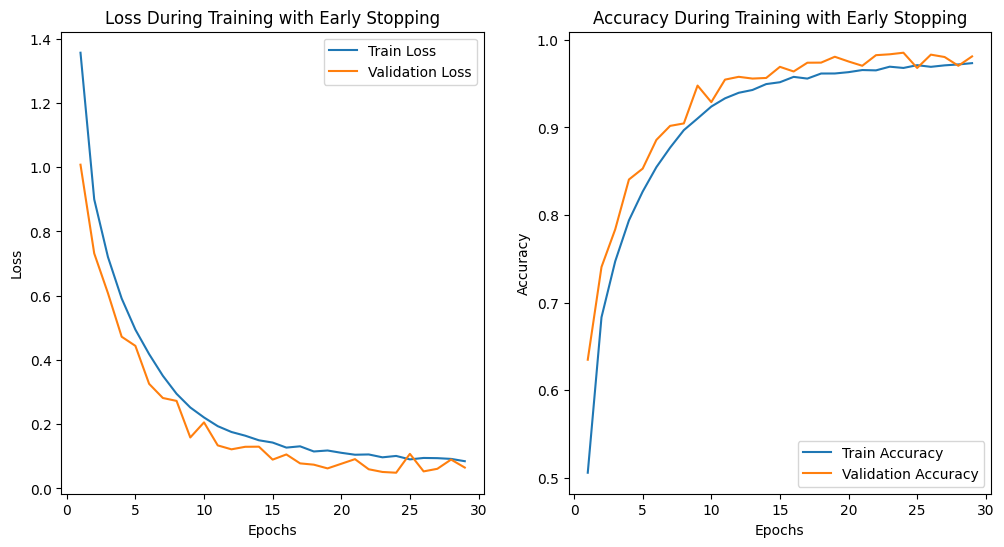

Testset Accuracy: 74.44%, Average Loss: 1.6931


In [8]:
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_history['train_loss']) + 1), train_history['train_loss'], label='Train Loss')
plt.plot(range(1, len(train_history['val_loss']) + 1), train_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training with Early Stopping')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_history['train_accuracy']) + 1), train_history['train_accuracy'], label='Train Accuracy')
plt.plot(range(1, len(train_history['val_accuracy']) + 1), train_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training with Early Stopping')
plt.legend()

plt.show()

# Test model
test_loss, test_accuracy = test_func(test_loader, model, loss_fn)

# Task 2

## Define CNN Model with Batch Normalisation

In [9]:
class CNNWithBN(nn.Module):
    def __init__(self):
        super(CNNWithBN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Implement Training Function

In [10]:
def train_model(train_loader, val_loader, model, loss_fn, optimizer, epochs=50):
  history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
  train_loss, train_correct, train_total = 0, 0, 0

  for epoch in range(epochs):
      model.train()
      train_loss = 0
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)

          output = model(data)
          loss = loss_fn(output, target)
          train_loss += loss.item()

          preds = output.argmax(dim=1)
          train_correct += (preds == target).sum().item()
          train_total += target.size(0)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      avg_train_loss = train_loss / len(train_loader)
      train_accuracy = train_correct / train_total

      model.eval()
      val_loss, val_correct, val_total = 0, 0, 0
      with torch.no_grad():
          for data, target in val_loader:
              data, target = data.to(device), target.to(device)

              output = model(data)
              loss = loss_fn(output, target)
              val_loss += loss.item()

              preds = output.argmax(dim=1)
              val_correct += (preds == target).sum().item()
              val_total += target.size(0)

      avg_val_loss = val_loss / len(val_loader)
      val_accuracy = val_correct / val_total

      history["train_loss"].append(avg_train_loss)
      history["val_loss"].append(avg_val_loss)
      history["train_accuracy"].append(train_accuracy)
      history["val_accuracy"].append(val_accuracy)

      print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

  return history

## Train and Validate Models with and without Batch Normalisation

In [11]:
model_no_bn = CNN(img_height, img_width, num_classes).to(device) # Original Model (Without BN)
model_bn = CNNWithBN().to(device) # BN Model

loss_fn = nn.CrossEntropyLoss()
optimizer_no_bn = torch.optim.Adam(model_no_bn.parameters(), lr=0.001)
optimizer_bn = torch.optim.Adam(model_bn.parameters(), lr=0.001)

print("Training without Batch Normalisation:")
history_no_bn = train_model(train_loader, val_loader, model_no_bn, loss_fn, optimizer_no_bn)
print("\nTraining with Batch Normalisation:")
history_bn = train_model(train_loader, val_loader, model_bn, loss_fn, optimizer_bn)

Training without Batch Normalisation:
Epoch 1/50, Train Loss: 1.3461, Train Acc: 0.5106, Val Loss: 0.9727, Val Acc: 0.6534
Epoch 2/50, Train Loss: 0.8894, Train Acc: 0.5992, Val Loss: 0.6743, Val Acc: 0.7693
Epoch 3/50, Train Loss: 0.7028, Train Acc: 0.6504, Val Loss: 0.5830, Val Acc: 0.7964
Epoch 4/50, Train Loss: 0.5819, Train Acc: 0.6872, Val Loss: 0.5205, Val Acc: 0.8137
Epoch 5/50, Train Loss: 0.4830, Train Acc: 0.7159, Val Loss: 0.3704, Val Acc: 0.8738
Epoch 6/50, Train Loss: 0.4015, Train Acc: 0.7397, Val Loss: 0.2851, Val Acc: 0.8989
Epoch 7/50, Train Loss: 0.3317, Train Acc: 0.7601, Val Loss: 0.2189, Val Acc: 0.9255
Epoch 8/50, Train Loss: 0.2727, Train Acc: 0.7781, Val Loss: 0.1912, Val Acc: 0.9366
Epoch 9/50, Train Loss: 0.2379, Train Acc: 0.7936, Val Loss: 0.1622, Val Acc: 0.9465
Epoch 10/50, Train Loss: 0.2104, Train Acc: 0.8068, Val Loss: 0.1565, Val Acc: 0.9487
Epoch 11/50, Train Loss: 0.1800, Train Acc: 0.8187, Val Loss: 0.1453, Val Acc: 0.9491
Epoch 12/50, Train Loss: 

## Visualise Performance with Convergence Graph

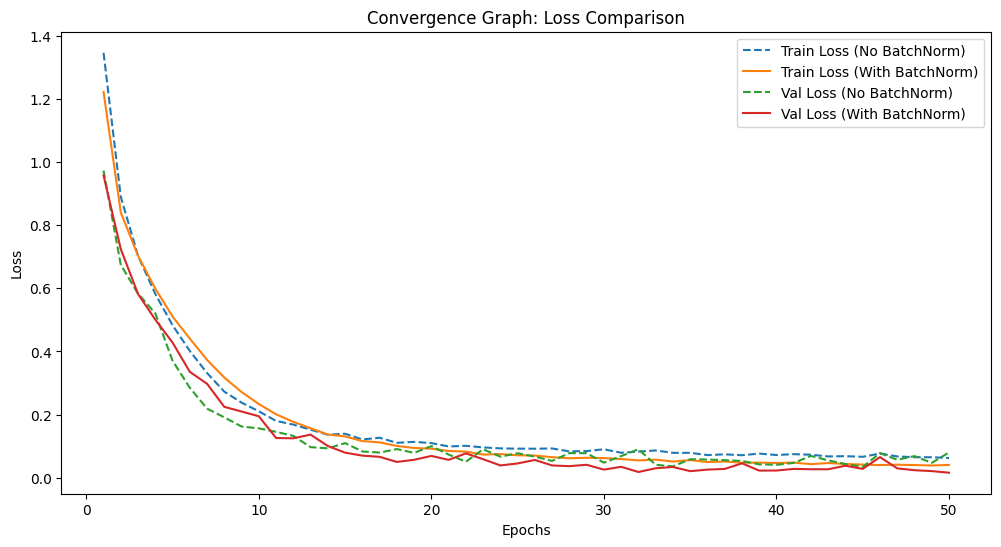

In [12]:
epochs = len(history_no_bn["train_loss"])
plt.figure(figsize=(12, 6))

# Training loss
plt.plot(range(1, epochs + 1), history_no_bn["train_loss"], label="Train Loss (No BatchNorm)", linestyle='--')
plt.plot(range(1, epochs + 1), history_bn["train_loss"], label="Train Loss (With BatchNorm)")

# Validation loss
plt.plot(range(1, epochs + 1), history_no_bn["val_loss"], label="Val Loss (No BatchNorm)", linestyle='--')
plt.plot(range(1, epochs + 1), history_bn["val_loss"], label="Val Loss (With BatchNorm)")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence Graph: Loss Comparison")
plt.legend()
plt.show()

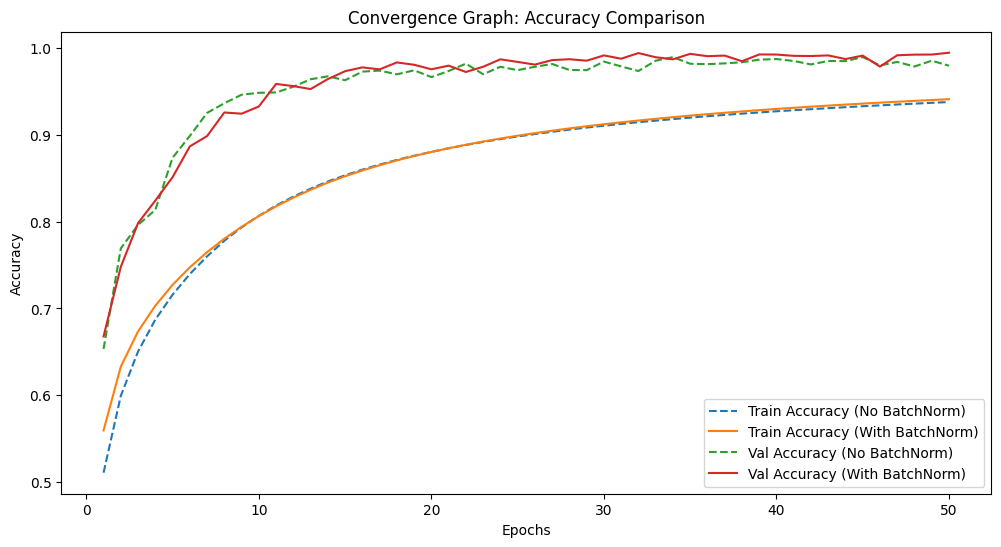

In [13]:
epochs = len(history_no_bn["train_accuracy"])
plt.figure(figsize=(12, 6))

# Training Accuracy
plt.plot(range(1, epochs + 1), history_no_bn["train_accuracy"], label="Train Accuracy (No BatchNorm)", linestyle='--')
plt.plot(range(1, epochs + 1), history_bn["train_accuracy"], label="Train Accuracy (With BatchNorm)")

# Validation Accuracy
plt.plot(range(1, epochs + 1), history_no_bn["val_accuracy"], label="Val Accuracy (No BatchNorm)", linestyle='--')
plt.plot(range(1, epochs + 1), history_bn["val_accuracy"], label="Val Accuracy (With BatchNorm)")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Convergence Graph: Accuracy Comparison")
plt.legend()
plt.show()

# Task 3

## Visualise Convolutional Features

In [14]:
def visualize_filters(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            filters = module.weight.data.cpu().numpy()
            num_filters = filters.shape[0]
            plt.figure(figsize=(12, 8))
            for i in range(min(num_filters, 16)):
                plt.subplot(4, 4, i + 1)
                plt.imshow(filters[i][0], cmap="viridis")
                plt.axis("off")
                plt.title(f"{name}: Filter {i}")
            plt.show()

# Adapted iterating layers from: https://www.geeksforgeeks.org/how-to-iterate-over-layers-in-pytorch/

## Visualise Feature Maps

In [15]:
def visualize_feature_maps(model, image):
    x = image.unsqueeze(0).to(device)
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Sequential):
            x = module(x)
            feature_maps = x.detach().cpu().numpy()
            num_maps = feature_maps.shape[1]
            plt.figure(figsize=(12, 8))
            for i in range(min(num_maps, 16)):
                plt.subplot(4, 4, i + 1)
                plt.imshow(feature_maps[0, i], cmap="viridis")
                plt.axis("off")
                plt.title(f"{name}: Feature Map {i}")
            plt.show()
        elif isinstance(module, nn.Linear):
            break

Files already downloaded and verified


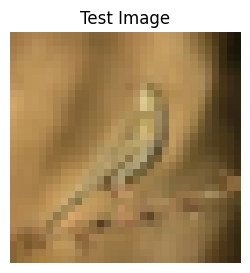

Visualizing Raw Filters


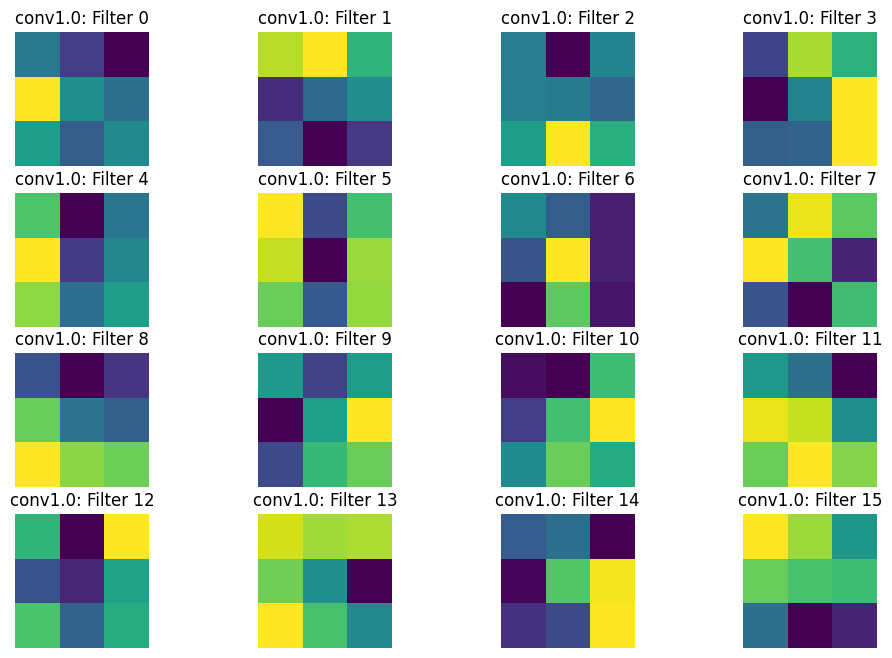

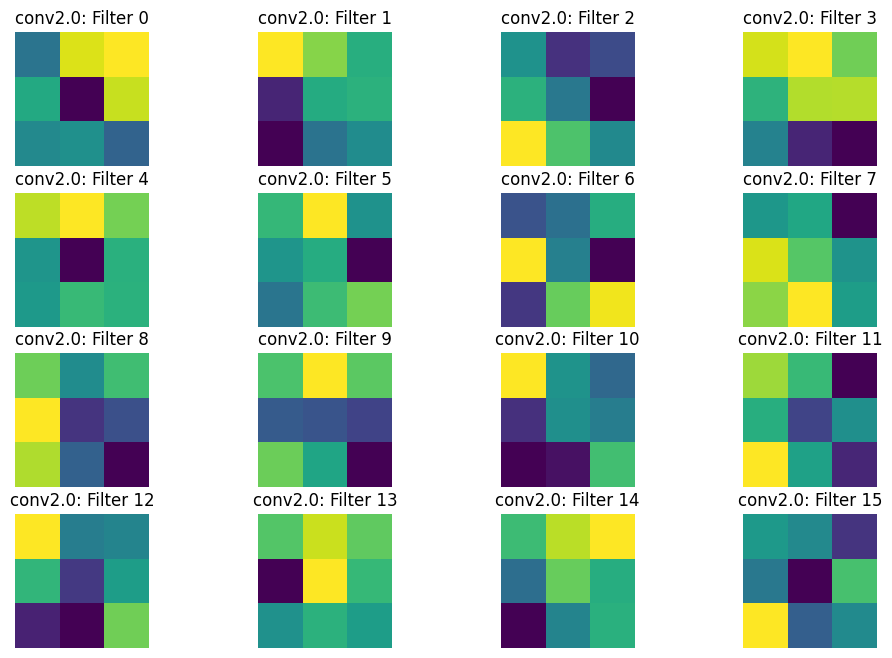

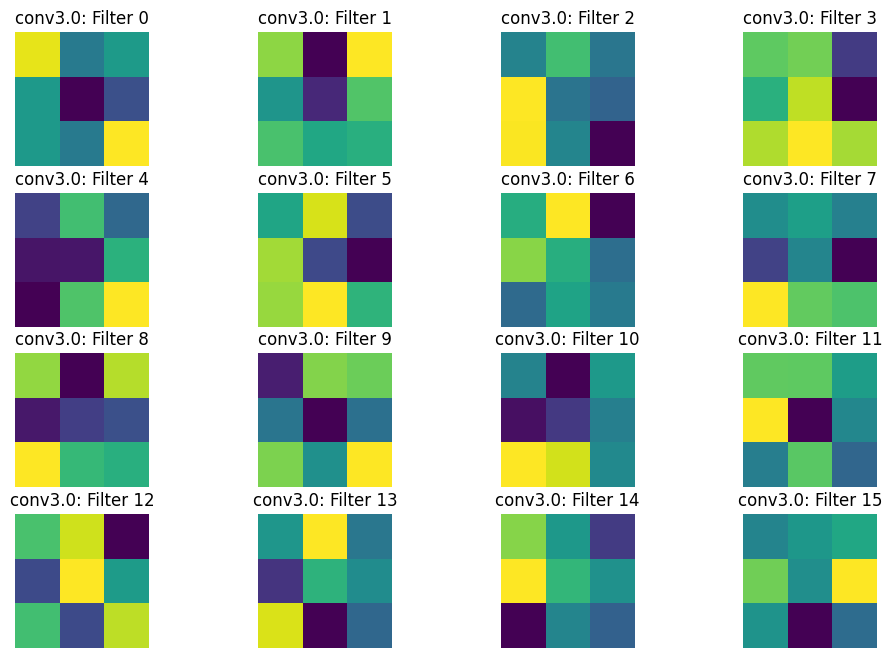

Visualizing Feature Maps


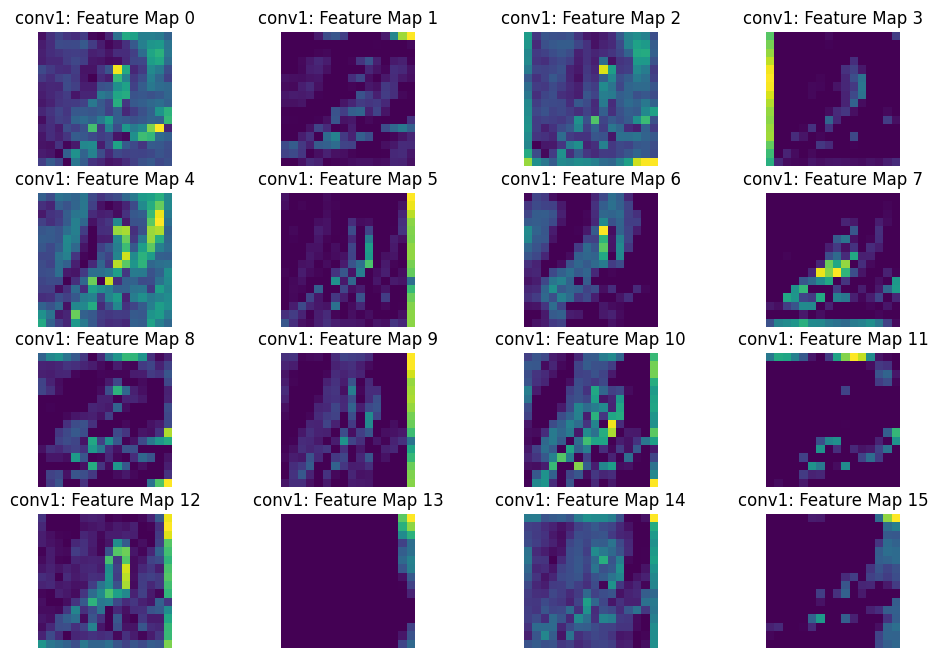

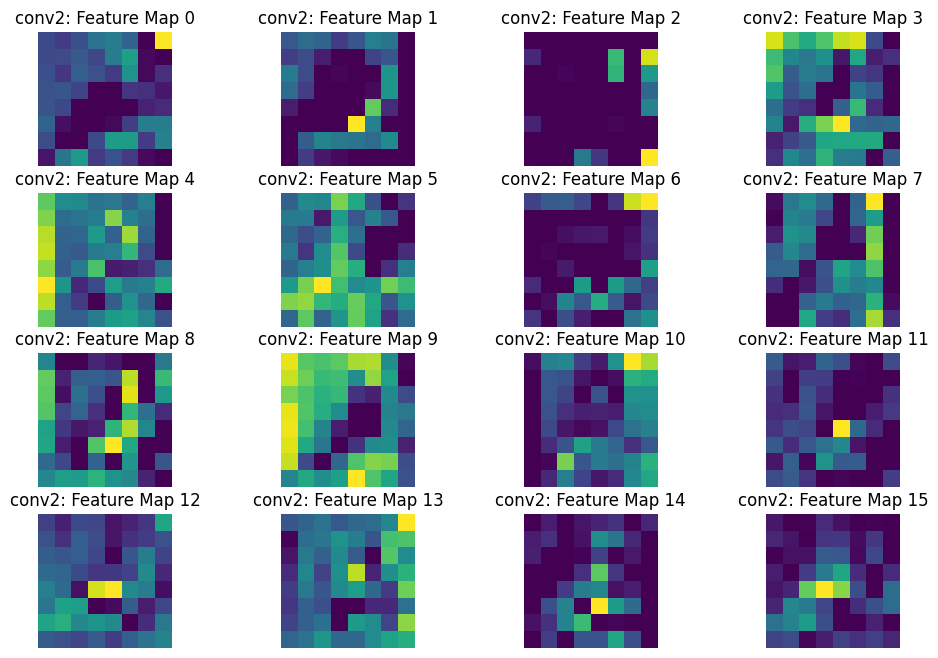

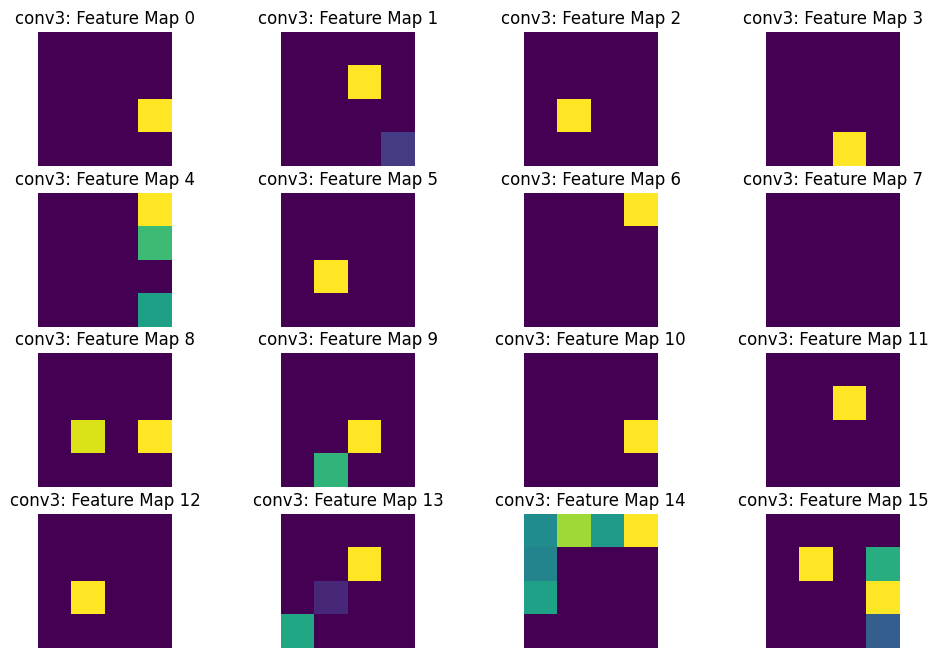

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
test_image, _ = next(iter(test_loader))

# Visualise a test image
plt.figure(figsize=(3, 3))
plt.imshow(test_image[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.axis("off")
plt.title("Test Image")
plt.show()

print("Visualizing Raw Filters")
visualize_filters(model_bn)

print("Visualizing Feature Maps")
visualize_feature_maps(model_bn, test_image[0])